In [2]:
# Initial imports
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import tensorflow as tf
get_ipython().run_line_magic("matplotlib", "inline")
%matplotlib inline

In [3]:
nltk.download("vader_lexicon")
analyzer = SentimentIntensityAnalyzer()


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/luisaguilar/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [4]:
# Load .env enviroment variables
load_dotenv()


# Set Alpaca API key and secret
alpaca_api_key = os.getenv('ALPACA_API_KEY')
alpaca_secret_key = os.getenv('ALPACA_SECRET_KEY')

api = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version='v2')

In [5]:
def stock_info_grab(ticker):
    """
    Takes ticker symbol and returns DataFrame with Date, Close, and Pct Change columns.
    """
    # Set timeframe to '1D'
    timeframe = "1D"

    # Set current date and the date from one month ago using the ISO format
    current_date = pd.Timestamp("2020-11-09", tz="America/New_York").isoformat()
    past_date = pd.Timestamp("2016-08-27", tz="America/New_York").isoformat()

    df = api.get_barset(
        ticker,
        timeframe,
        limit=None,
        start=past_date,
        end=current_date,
        after=None,
        until=None,
    ).df
    df = df.droplevel(axis=1, level=0)
    df.index = df.index.date
    df['pct change'] = df['close'].pct_change()
    df['pct change'].dropna
    df = df.reset_index()
    df = df.drop(columns=['open', 'high', 'low', 'volume'])
    df = df.rename(columns={'index':'Date'})
    df = df.set_index('Date')
    return df

In [6]:
aapl_stock_info = stock_info_grab("AAPL")
amzn_stock_info = stock_info_grab("AMZN")
tsla_stock_info = stock_info_grab("TSLA")
spy_stock_info = stock_info_grab("SPY")
aapl_stock_info

,close,pct change
Date,,
2016-08-29,106.820,NaN
2016-08-30,105.990,-0.007770
2016-08-31,106.110,0.001132
2016-09-01,106.730,0.005843
2016-09-02,107.730,0.009369
...,...,...
2020-11-03,110.375,0.014756
2020-11-04,114.940,0.041359
2020-11-05,118.990,0.035236


In [7]:
aapl_file = Path('../Resources/AAPL_HEADLINES.csv')
#amzn_file = Path('../Resources/AMZN_HEADLINES.csv')
spy_file = Path('../Resources/SPY_HEADLINES.csv')
tsla_file = Path('../Resources/TSLA_HEADLINES.csv')

aapl_headlines_df = pd.read_csv(aapl_file)
#amzn_headlines_df = pd.read_csv(amzn_file)
spy_headlines_df = pd.read_csv(spy_file)
tsla_headlines_df = pd.read_csv(tsla_file)

#aapl_headlines['Date'] = pd.to_datetime(aapl_headlines['Date']).dt.strftime('%Y-%m-%d')
#aapl_headlines = aapl_headlines.set_index('Date')
aapl_headlines_df

,Headline,Date
0,"Apple Inc. stock falls Monday, underperforms m...","Nov. 9, 2020 at 4:30 p.m. ET"
1,Big Tech Stocks Are Lagging Today. Why They’ll...,"Nov. 9, 2020 at 1:45 p.m. ET"
2,"As Apple releases its new line of Macs, the bi...","Nov. 9, 2020 at 1:18 p.m. ET"
3,"In the Midst of Election Uncertainty, Younger ...","Nov. 6, 2020 at 9:21 p.m. ET"
4,Berkshire Buybacks Hit Record $9 Billion in Th...,"Nov. 7, 2020 at 8:49 a.m. ET"
...,...,...
9868,Respect for America has climbed during the Oba...,"Aug. 29, 2016 at 11:47 a.m. ET"
9869,"Fitbit upgrades now track yoga, weightlifting ...","Aug. 29, 2016 at 9:41 a.m. ET"
9870,5 things Tim Cook has done better at Apple tha...,"Aug. 28, 2016 at 9:15 p.m. ET"
9871,Want to invest in self-driving cars? Check out...,"Aug. 27, 2016 at 11:02 a.m. ET"


In [8]:
def get_sentiment(score):
    """
    Calculates the sentiment based on the compound score.
    """
    result = 0  # Neutral by default
    if score >= 0.05:  # Positive
        result = 1
    elif score <= -0.05:  # Negative
        result = -1

    return result


In [9]:
def create_sentiment_df(df):
    """
    Takes headlines DataFrame & creates DataFrame with Sentiment columns.
    Splits Date & Time, creates Time column and moves Date to Index.
    """
    title_sent = {
        "compound": [],
        "positive": [],
        "neutral": [],
        "negative": [],
        "sentiment": [],
    }

    for index, row in df.iterrows():
        try:
            # Sentiment scoring with VADER
            title_sentiment = analyzer.polarity_scores(row["Headline"])
            title_sent["compound"].append(title_sentiment["compound"])
            title_sent["positive"].append(title_sentiment["pos"])
            title_sent["neutral"].append(title_sentiment["neu"])
            title_sent["negative"].append(title_sentiment["neg"])
            title_sent["sentiment"].append(get_sentiment(title_sentiment["compound"]))
        except AttributeError:
            pass

    title_sent_df = pd.DataFrame(title_sent)
    #title_sent_df.head()

    headline_sentiment_df = df.join(title_sent_df)
    headline_sentiment_df.dropna()
    headline_sentiment_df['Date'] = headline_sentiment_df['Date'].str.replace('at','-')
    headline_sentiment_df['Date'] = headline_sentiment_df['Date'].str.split('-').str[0]
    headline_sentiment_df = headline_sentiment_df.reindex(columns=['Date', 'Headline', 'compound', 'positive', 'neutral', 'negative', 'sentiment'])
    headline_sentiment_df['Date'] = pd.to_datetime(headline_sentiment_df['Date'])
    headline_sentiment_df.set_index('Date')
    return headline_sentiment_df

In [10]:
aapl_headlines = create_sentiment_df(aapl_headlines_df)
#amzn_headlines = create_sentiment_df(amzn_headlines_df)
tsla_headlines = create_sentiment_df(tsla_headlines_df)
spy_headlines = create_sentiment_df(spy_headlines_df)
aapl_headlines

,Date,Headline,compound,positive,neutral,negative,sentiment
0,2020-11-09,"Apple Inc. stock falls Monday, underperforms m...",0.0000,0.000,1.000,0.000,0
1,2020-11-09,Big Tech Stocks Are Lagging Today. Why They’ll...,-0.0772,0.121,0.738,0.141,-1
2,2020-11-09,"As Apple releases its new line of Macs, the bi...",0.4767,0.193,0.807,0.000,1
3,2020-11-06,"In the Midst of Election Uncertainty, Younger ...",-0.3400,0.000,0.806,0.194,-1
4,2020-11-07,Berkshire Buybacks Hit Record $9 Billion in Th...,-0.1531,0.000,0.882,0.118,-1
...,...,...,...,...,...,...,...
9868,2016-08-29,Respect for America has climbed during the Oba...,0.4767,0.279,0.721,0.000,1
9869,2016-08-29,"Fitbit upgrades now track yoga, weightlifting ...",0.0000,0.000,1.000,0.000,0
9870,2016-08-28,5 things Tim Cook has done better at Apple tha...,0.4404,0.209,0.791,0.000,1
9871,2016-08-27,Want to invest in self-driving cars? Check out...,0.0772,0.126,0.874,0.000,1


In [11]:
# find average sentiment score by date
aapl_scores = aapl_headlines.groupby('Date').mean().sort_values(by='Date')
#amzn_scores = amzn_headlines.groupby(['Date']).mean().sort_values(by='Date')
tsla_scores = tsla_headlines.groupby(['Date']).mean().sort_values(by='Date')
spy_scores = spy_headlines.groupby(['Date']).mean().sort_values(by='Date')

In [12]:
aapl_scores.head()

,compound,positive,neutral,negative,sentiment
Date,,,,,
2016-03-19,0.836000,0.530000,0.470000,0.000000,1.000000
2016-08-27,0.038600,0.063000,0.937000,0.000000,0.500000
2016-08-28,0.440400,0.209000,0.791000,0.000000,1.000000
2016-08-29,0.067100,0.102000,0.842286,0.055714,0.000000
2016-08-30,-0.015205,0.061591,0.883455,0.054955,-0.090909


In [13]:
# TO DO: drop compund col on all scores
aapl_scores = aapl_scores.drop(columns='compound')
#amzn_scores = amzn_scores.drop(columns='compound')
tsla_scores = tsla_scores.drop(columns='compound')
spy_scores = spy_scores.drop(columns='compound')

In [14]:
# sent scores distribution across each df poss use histogram, calc meanstd, or percentiles 
aapl_complete = pd.concat([aapl_scores,aapl_stock_info], join='outer', axis=1).dropna()
#amzn_complete = pd.concat([amzn_scores,amzn_stock_info], join='outer', axis=1).dropna()
tsla_complete = pd.concat([tsla_scores,tsla_stock_info], join='outer', axis=1).dropna()
spy_complete = pd.concat([spy_scores,spy_stock_info], join='outer', axis=1).dropna()
aapl_complete

,positive,neutral,negative,sentiment,close,pct change
Date,,,,,,
2016-08-30,0.061591,0.883455,0.054955,-0.090909,105.990,-0.007770
2016-08-31,0.070400,0.818600,0.111000,-0.200000,106.110,0.001132
2016-09-01,0.069625,0.897625,0.032750,0.125000,106.730,0.005843
2016-09-02,0.063143,0.845429,0.091429,-0.285714,107.730,0.009369
2016-09-06,0.131750,0.804500,0.063750,0.250000,107.700,-0.000278
...,...,...,...,...,...,...
2020-11-03,0.119000,0.842000,0.038833,0.500000,110.375,0.014756
2020-11-04,0.078900,0.800900,0.120300,-0.300000,114.940,0.041359
2020-11-05,0.202333,0.747333,0.050333,0.333333,118.990,0.035236


In [15]:
# TO DO: shift aapl_complete['pct change'] one day on all dfs
# TO DO: dropna() on all df['predicted pct change'] cols 
aapl_complete['predicted pct change'] = aapl_complete['pct change'].shift(periods=1)
#amzn_complete['predicted pct change'] = amzn_complete['pct change'].shift(periods=1)
tsla_complete['predicted pct change'] = tsla_complete['pct change'].shift(periods=1)
spy_complete['predicted pct change'] = spy_complete['pct change'].shift(periods=1)


In [16]:
aapl_complete = aapl_complete.dropna()
#amzn_complete = amzn_complete.dropna()
tsla_complete = tsla_complete.dropna()
spy_complete = spy_complete.dropna()


In [17]:
def get_sentiment(df):
    """
    Calculates the sentiment based on the compound score.
    """
    result = [
        (df['sentiment'] >= 0.10),
        (df['sentiment'] > -0.10) & (df['sentiment'] < 0.10),
        (df['sentiment'] <= -0.10)
    ]
    
    values = ['sell', 'hold', 'buy']
    
    df['buy/hold/sell'] = np.select(result, values)
    
    return df

In [18]:
aapl_complete_sentiment = get_sentiment(aapl_complete)
#amzn_complete_sentiment = get_sentiment(amzn_complete)
tsla_complete_sentiment = get_sentiment(tsla_complete)
spy_complete_sentiment = get_sentiment(spy_complete)
aapl_complete_sentiment

/Users/luisaguilar/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


,positive,neutral,negative,sentiment,close,pct change,predicted pct change,buy/hold/sell
Date,,,,,,,,
2016-08-31,0.070400,0.818600,0.111000,-0.200000,106.110,0.001132,-0.007770,buy
2016-09-01,0.069625,0.897625,0.032750,0.125000,106.730,0.005843,0.001132,sell
2016-09-02,0.063143,0.845429,0.091429,-0.285714,107.730,0.009369,0.005843,buy
2016-09-06,0.131750,0.804500,0.063750,0.250000,107.700,-0.000278,0.009369,sell
2016-09-07,0.096000,0.877000,0.027000,0.250000,108.370,0.006221,-0.000278,sell
...,...,...,...,...,...,...,...,...
2020-11-03,0.119000,0.842000,0.038833,0.500000,110.375,0.014756,-0.001194,sell
2020-11-04,0.078900,0.800900,0.120300,-0.300000,114.940,0.041359,0.014756,buy
2020-11-05,0.202333,0.747333,0.050333,0.333333,118.990,0.035236,0.041359,sell


In [19]:
df = aapl_complete_sentiment

In [20]:
df

,positive,neutral,negative,sentiment,close,pct change,predicted pct change,buy/hold/sell
Date,,,,,,,,
2016-08-31,0.070400,0.818600,0.111000,-0.200000,106.110,0.001132,-0.007770,buy
2016-09-01,0.069625,0.897625,0.032750,0.125000,106.730,0.005843,0.001132,sell
2016-09-02,0.063143,0.845429,0.091429,-0.285714,107.730,0.009369,0.005843,buy
2016-09-06,0.131750,0.804500,0.063750,0.250000,107.700,-0.000278,0.009369,sell
2016-09-07,0.096000,0.877000,0.027000,0.250000,108.370,0.006221,-0.000278,sell
...,...,...,...,...,...,...,...,...
2020-11-03,0.119000,0.842000,0.038833,0.500000,110.375,0.014756,-0.001194,sell
2020-11-04,0.078900,0.800900,0.120300,-0.300000,114.940,0.041359,0.014756,buy
2020-11-05,0.202333,0.747333,0.050333,0.333333,118.990,0.035236,0.041359,sell


## Linear Regression

In [4]:
train = df.loc['2008':'2012']

test = df.loc['2013']

In [5]:
# Create dataframes for X_train and X_test
# Create series for y_train and y_test
# X_train (training set using just the independent variables), X_test (test set of of just the independent variables)
# Y_train (training set using just the "y" variable, i.e., "Futures Return"), Y_test (test set of just the "y" variable):
X_train = train["Lagged_Return"].to_frame()
X_test = test["Lagged_Return"].to_frame()
y_train = train["Return"]
y_test = test["Return"]

In [6]:
X_train.head()

,Lagged_Return
Date,
2008-01-02,-0.685159
2008-01-03,-1.443784
2008-01-04,0.000000
2008-01-07,-2.455155
2008-01-08,0.322326


In [7]:
y_train.head()

Date
2008-01-02   -1.443784
2008-01-03    0.000000
2008-01-04   -2.455155
2008-01-07    0.322326
2008-01-08   -1.835227
Name: Return, dtype: float64

# Fit the model to the Training Data

In [1]:
from sklearn.linear_model import LinearRegression

In [9]:
#Fit a SKLearn linear regression using  just the training set (X_train, Y_train):
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

# Make predictions using the Testing Data

Note: We want to evaluate the model using data that it has never seen before, in this case: X_test.

In [10]:
# And make a prediction of "y" values for just the test dataset
predictions = model.predict(X_test)

In [11]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
Results = y_test.to_frame()
Results["Predicted Return"] = predictions

In [12]:
Results.head(2)

,Return,Predicted Return
Date,,
2013-01-02,2.540342,-0.188503
2013-01-03,-0.208562,-0.288921


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa248f94d10>,
      dtype=object)

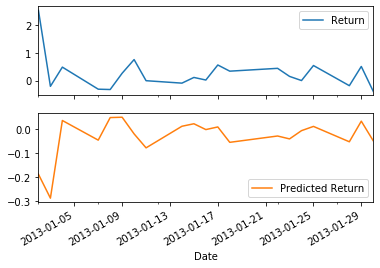

In [13]:
# Plot the first 20 predictions against the true values to see how it performed
# The trends lines should be similar
Results[:20].plot(subplots=True)

# Out-of-Sample Performance

Evaluate the model using "out-of-sample" data (X_test and y_test)

In [14]:
from sklearn.metrics import mean_squared_error, r2_score
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
# (Hint: use the dataframe above)
mse = mean_squared_error(
    Results["Return"],
    Results["Predicted Return"]
)

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
rmse = np.sqrt(mse)
print(f"Out-of-Sample Root Mean Squared Error (RMSE): {rmse}")

Out-of-Sample Root Mean Squared Error (RMSE): 0.7037691017337323


# In-Sample Performance

Evaluate the model using in-sample data (X_train and y_train)

In [15]:
# Construct a dataframe using just the "y" training data:
in_sample_results = y_train.to_frame()

# Add a column of "in-sample" predictions to that DataFrame:  
in_sample_results["In-sample Predictions"] = model.predict(X_train)

# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
in_sample_mse = mean_squared_error(
    in_sample_results["Return"],
    in_sample_results["In-sample Predictions"]
)

# Calculate in-sample root mean_squared_error (for comparison to out-of-sample)
in_sample_rmse = np.sqrt(in_sample_mse)
print(f"In-sample Root Mean Squared Error (RMSE): {in_sample_rmse}")

In-sample Root Mean Squared Error (RMSE): 1.6450198277763866


In [99]:
# Create a Linear Regression Model using sklearn
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model

LinearRegression()

## Fit the Model to the Data

In [100]:

X = df.copy()
X = df[["positive", "neutral", "negative", "sentiment"]].values
#X = X.reshape(-1, 1)
X[:5]

array([[ 0.0704    ,  0.8186    ,  0.111     , -0.2       ],
       [ 0.069625  ,  0.897625  ,  0.03275   ,  0.125     ],
       [ 0.06314286,  0.84542857,  0.09142857, -0.28571429],
       [ 0.13175   ,  0.8045    ,  0.06375   ,  0.25      ],
       [ 0.096     ,  0.877     ,  0.027     ,  0.25      ]])

In [101]:
X.shape

(1049, 4)

In [102]:
#X = X.reshape(X.shape[1052, 4])


In [110]:

y = df["pct change"].values
#y = df["pct change"].shift(periods=1).values
y = y.reshape(-1, 1)
y[:5]

array([[ 0.00113218],
       [ 0.00584299],
       [ 0.00936944],
       [-0.00027847],
       [ 0.00622098]])

In [111]:
y.shape

(1049, 1)

In [112]:
# Fit the model to the data
results = model.fit(X, y)


## Make Predictions

In [113]:
# Make predictions using the X data
predicted_y_values = model.predict(X)
predicted_y_values

array([[-0.00283651],
       [ 0.00211529],
       [-0.00210365],
       ...,
       [ 0.00541104],
       [-0.00426934],
       [ 0.00511573]])

### Extract the coef, intercept, and calculate the score of the model

In [114]:
model.coef_

array([[-9.53245951e+00, -9.55949343e+00, -9.61521617e+00,
         1.88447416e-03]])

In [115]:
model.intercept_

array([9.56131585])

In [116]:
# R2 value
model.score(X, y, sample_weight=None)

0.020815761935934374

ValueError: x and y must be the same size

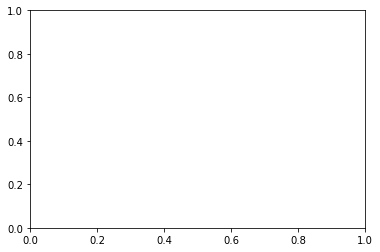

In [28]:
# Plot X and y as a scatter plot
# Plot X and the predictions as a red line plot
plt.scatter(X, y)
plt.plot(X, predicted_y_values, color='red')

### Extract the coef, intercept, and calculate the score of the model

In [9]:
model.coef_

array([117841.63757442])

In [10]:
model.intercept_

408619.81940216525

In [11]:
# R2 value
model.score(X, y, sample_weight=None)

0.11267062525400562

## Logistic Regression


  ## Separate the Features (X) from the Target (y)

In [46]:

X = df.copy()
X = df[["positive", "neutral", "negative", "sentiment"]].values
#X = X.reshape(-1, 1)
X[:5]

array([[ 0.06159091,  0.88345455,  0.05495455, -0.09090909],
       [ 0.0704    ,  0.8186    ,  0.111     , -0.2       ],
       [ 0.069625  ,  0.897625  ,  0.03275   ,  0.125     ],
       [ 0.06314286,  0.84542857,  0.09142857, -0.28571429],
       [ 0.13175   ,  0.8045    ,  0.06375   ,  0.25      ]])

In [47]:
X.shape

(1051, 4)

In [48]:
#X = X.reshape(X.shape[1052, 4])


In [62]:

y = df["predicted pct change"].values
#y = df["pct change"].shift(periods=1).values
y = y.reshape(-1, 1)
y[:5]

array([[ 0.00113218],
       [ 0.00584299],
       [ 0.00936944],
       [-0.00027847],
       [ 0.00622098]])

In [63]:
y.shape

(1051, 1)

  ## Split our data into training and testing

In [64]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test= train_test_split(X, 
                                                   y, 
                                                   random_state=1, 
                                                   stratify=y)
X_train.shape

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

  ## Create a Logistic Regression Classifier

In [52]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(solver='lbfgs', random_state=1)
classifier

LogisticRegression(random_state=1)

  ## Fit (train) or model using the training data

In [53]:
classifier.fit(X_train, y_train.ravel())

LogisticRegression(random_state=1)

In [57]:
print(type(y_train))

<class 'numpy.ndarray'>


  ## Score the model using the test data

In [54]:
print(f"Training Data Score: {classifier.score(X_train, y_train)}")
print(f"Testing Data Score: {classifier.score(X_test, y_test)}")

Training Data Score: 0.9708121827411168
Testing Data Score: 0.9695817490494296


  ## Make predictions

In [59]:
predictions = classifier.predict(X_test)
#results = pd.DataFrame({"Prediction": predictions,
                        #"Actual": y_test}).reset_index(drop=True)
#results.head()

  # Confusion Matrix

In [60]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

array([[ 75,   0,   0],
       [  3,  48,   5],
       [  0,   0, 132]])

  # Classification Report

In [61]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         buy       0.96      1.00      0.98        75
        hold       1.00      0.86      0.92        56
        sell       0.96      1.00      0.98       132

    accuracy                           0.97       263
   macro avg       0.98      0.95      0.96       263
weighted avg       0.97      0.97      0.97       263



## Neural Network

In [110]:
# Define features data
#X = df[['positive', 'neutral', 'negative','sentiment']].values
#X = X.drop(columns=["pct change"])


#X[:5]

X = df.copy()
X =df['sentiment'].values
#X = df[['positive', 'neutral', 'negative','sentiment']].values
#X = X.drop(columns=["close", "pct change", "predicted pct change"]).values
X = X.reshape(-1, 1)
X[:5]

array([[-0.09090909],
       [-0.2       ],
       [ 0.125     ],
       [-0.28571429],
       [ 0.25      ]])

In [111]:
# Define target data
y = df["pct change"].values
#y = df["pct change"].shift(periods=1).values
y = y.reshape(-1, 1)
y[:5]

array([[-0.00777008],
       [ 0.00113218],
       [ 0.00584299],
       [ 0.00936944],
       [-0.00027847]])

In [112]:
# Create training and testing datasets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [113]:
# Create the scaler instance
from sklearn.preprocessing import StandardScaler

X_scaler = StandardScaler()

In [114]:
# Fit the scaler
X_scaler.fit(X_train)

StandardScaler()

In [115]:
# Scale the features data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [116]:
# Define the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

number_inputs = 1
number_hidden_nodes = 4

nn = Sequential()
nn.add(Dense(units=number_hidden_nodes, input_dim=number_inputs, activation="relu"))
nn.add(Dense(1, activation="sigmoid"))

In [117]:
# Compile model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [93]:
# Fit the model
model = nn.fit(X_train_scaled, y_train, epochs=100)

Epoch 1/100
25/25 [==============================] - 0s 1ms/step - loss: 0.6168 - accuracy: 0.0025
Epoch 2/100
25/25 [==============================] - 0s 2ms/step - loss: 0.5825 - accuracy: 0.0038
Epoch 3/100
25/25 [==============================] - 0s 3ms/step - loss: 0.5491 - accuracy: 0.0038
Epoch 4/100
25/25 [==============================] - 0s 2ms/step - loss: 0.5161 - accuracy: 0.0038
Epoch 5/100
25/25 [==============================] - 0s 2ms/step - loss: 0.4839 - accuracy: 0.0038
Epoch 6/100
25/25 [==============================] - 0s 2ms/step - loss: 0.4523 - accuracy: 0.0038
Epoch 7/100
25/25 [==============================] - 0s 2ms/step - loss: 0.4216 - accuracy: 0.0038
Epoch 8/100
25/25 [==============================] - 0s 2ms/step - loss: 0.3918 - accuracy: 0.0038
Epoch 9/100
25/25 [==============================] - 0s 1ms/step - loss: 0.3631 - accuracy: 0.0038
Epoch 10/100
25/25 [==============================] - 0s 2ms/step - loss: 0.3357 - accuracy: 0.0038
Epoch 11/

<AxesSubplot:>

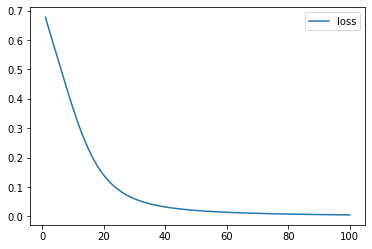

In [84]:
# Create a dataframe with the history dictionary
df_plot = pd.DataFrame(model.history, index=range(1, len(model.history["loss"]) + 1))

# Plot the loss
df_plot.plot(y="loss")

<AxesSubplot:>

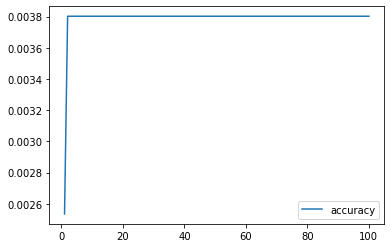

In [85]:
# Plot the accuracy
df_plot.plot(y="accuracy")

In [86]:
# Evaluate the model fit with linear dummy data
model_loss, model_accuracy = nn.evaluate(X_test_scaled, y_test, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

9/9 - 0s - loss: 0.0162 - accuracy: 0.0000e+00
Loss: 0.016187742352485657, Accuracy: 0.0


In [87]:
# Define the model with "Hard Sigmoid" activation
number_inputs = 1
number_hidden_nodes = 120

nn_2 = Sequential()
nn_2.add(Dense(units=number_hidden_nodes, input_dim=number_inputs, activation="tanh"))
nn_2.add(Dense(units=1, activation="hard_sigmoid"))

In [88]:
# Compile model
nn_2.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [89]:
# Fit the model
model_2 = nn_2.fit(X_train_scaled, y_train, epochs=100)

Epoch 1/100
25/25 [==============================] - 0s 1ms/step - loss: 0.6309 - accuracy: 0.0038
Epoch 2/100
25/25 [==============================] - 0s 2ms/step - loss: 0.4839 - accuracy: 0.0038
Epoch 3/100
25/25 [==============================] - 0s 4ms/step - loss: 0.3103 - accuracy: 0.0038
Epoch 4/100
25/25 [==============================] - 0s 2ms/step - loss: 0.1167 - accuracy: 0.0038
Epoch 5/100
25/25 [==============================] - 0s 1ms/step - loss: -0.0012 - accuracy: 0.0038
Epoch 6/100
25/25 [==============================] - 0s 2ms/step - loss: 0.0050 - accuracy: 0.0038
Epoch 7/100
25/25 [==============================] - 0s 1ms/step - loss: 0.0050 - accuracy: 0.0038
Epoch 8/100
25/25 [==============================] - 0s 1ms/step - loss: 0.0018 - accuracy: 0.0038
Epoch 9/100
25/25 [==============================] - 0s 1ms/step - loss: 0.0049 - accuracy: 0.0038
Epoch 10/100
25/25 [==============================] - 0s 1ms/step - loss: 0.0051 - accuracy: 0.0038
Epoch 11

In [137]:
# Evaluate the model fit with linear dummy data
model_loss_2, model_accuracy_2 = nn_2.evaluate(X_test_scaled, y_test, verbose=2)
print(f"Loss: {model_loss_2}, Accuracy: {model_accuracy_2}")

9/9 - 0s - loss: 0.0377 - accuracy: 0.0000e+00
Loss: 0.037722621113061905, Accuracy: 0.0


## Logistic Regression Model

In [50]:
y = df["pct change"]
X = df.drop(columns="pct change")

In [51]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test= train_test_split(X, 
                                                   y, 
                                                   random_state=1, 
                                                   stratify=y)
X_train.shape

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

## Scoring Sentiment Using RNN LSTM

In [39]:
df = aapl_complete

In [40]:
def window_data(df, window, feature_col_number, target_col_number):
    """
    This function accepts the column number for the features (X) and the target (y).
    It chunks the data up with a rolling window of Xt - window to predict Xt.
    It returns two numpy arrays of X and y.
    """
    X = []
    y = []
    for i in range(len(df) - window):
        features = df.iloc[i : (i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [46]:
# Creating the features (X) and target (y) data using the window_data() function.
window_size = 5

feature_column = 6
target_column = 6
X, y = window_data(df, window_size, feature_column, target_column)
print (f"X sample values:\n{X[:5]} \n")
print (f"y sample values:\n{y[:5]}")

X sample values:
[[-0.00777008  0.00113218  0.00584299  0.00936944 -0.00027847]
 [ 0.00113218  0.00584299  0.00936944 -0.00027847  0.00622098]
 [ 0.00584299  0.00936944 -0.00027847  0.00622098 -0.02639107]
 [ 0.00936944 -0.00027847  0.00622098 -0.02639107 -0.02246233]
 [-0.00027847  0.00622098 -0.02639107 -0.02246233  0.02229979]] 

y sample values:
[[ 0.00622098]
 [-0.02639107]
 [-0.02246233]
 [ 0.02229979]
 [ 0.02446889]]


In [45]:

#X = aapl_complete["Headline"].values
#y = aapl_sentiment["close"].values

In [25]:
# Create the features set (X) and the target vector (y)
x_cols = [i for i in aapl_complete.columns if i not in ("pct change")]
X = aapl_complete[x_cols]
y = aapl_complete["pct change"]
X

,compound,positive,neutral,negative,sentiment,close
Date,,,,,,
2016-08-30,-0.015205,0.061591,0.883455,0.054955,-0.090909,105.990
2016-08-31,-0.043420,0.070400,0.818600,0.111000,-0.200000,106.110
2016-09-01,0.009625,0.069625,0.897625,0.032750,0.125000,106.730
2016-09-02,-0.087129,0.063143,0.845429,0.091429,-0.285714,107.730
2016-09-06,0.093200,0.131750,0.804500,0.063750,0.250000,107.700
...,...,...,...,...,...,...
2020-11-03,0.181500,0.119000,0.842000,0.038833,0.500000,110.375
2020-11-04,-0.038410,0.078900,0.800900,0.120300,-0.300000,114.940
2020-11-05,0.304967,0.202333,0.747333,0.050333,0.333333,118.990


In [18]:
# Create the train, test, and validation sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train)

In [19]:
# Import the Tokenizer method from Keras
from tensorflow.keras.preprocessing.text import Tokenizer

In [26]:
# Create an instance of the Tokenizer and fit it with the X text data
#tokenizer = Tokenizer(lower=True)
#tokenizer.fit_on_texts(X)

In [27]:
# Print the first five elements of the encoded vocabulary
#for token in list(tokenizer.word_index)[:5]:
    #print(f"word: '{token}', token: {tokenizer.word_index[token]}")

In [28]:
# Transform the text data to numerical sequences
#X_seq = tokenizer.texts_to_sequences(X)

In [29]:
# Contrast a sample numerical sequence with its text version
#print("**Text comment**")
#print({X[1]})

In [31]:
#print("**Numerical sequence representation**")
#print(X_[0])

In [32]:
# Import the pad_sequences method from Keras
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [33]:
# Set the pad size
#max_words = 30

# Pad the sequences using the pad_sequences() method
#X_pad = pad_sequences(X_seq, maxlen=max_words, padding="post")

In [34]:
#print(X_pad)

In [35]:
# Creating training, validation, and testing sets using the encoded data
#X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = train_test_split(X_pad, y)

#X_train_rnn, X_val_rnn, y_train_rnn, y_val_rnn = train_test_split(X_train_rnn, y_train_rnn)

In [36]:
# Import Keras modules for model creation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

In [58]:
# Model set-up
#vocabulary_size = len(tokenizer.word_counts.keys()) + 1
#embedding_size = 64

In [81]:
# Define the LSTM RNN model
model = Sequential()

# Layer 1
#model.add(Embedding(vocabulary_size, embedding_size, input_length=max_words))

# Layer 2
model.add(LSTM(units=5))

# Output layer
model.add(Dense(units=1, activation="sigmoid"))

In [82]:
# Compile the model
model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=[
        "accuracy",
        tf.keras.metrics.TruePositives(name="tp"),
        tf.keras.metrics.TrueNegatives(name="tn"),
        tf.keras.metrics.FalsePositives(name="fp"),
        tf.keras.metrics.FalseNegatives(name="fn"),
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.AUC(name="auc"),
    ],
)

In [83]:
# Show model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 30, 64)            3328      
_________________________________________________________________
lstm_2 (LSTM)                (None, 5)                 1400      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 4,734
Trainable params: 4,734
Non-trainable params: 0
_________________________________________________________________


In [84]:
# Training the model
batch_size = 1000
epochs = 10
model.fit(
    X_train_rnn,
    y_train_rnn,
    validation_data=(X_val_rnn, y_val_rnn),
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,
)

Epoch 1/10
1/1 [==============================] - 1s 1s/step - loss: 0.7537 - accuracy: 0.0000e+00 - tp: 1.0000 - tn: 0.0000e+00 - fp: 1.0000 - fn: 0.0000e+00 - precision: 0.5000 - recall: 1.0000 - auc: 0.5000 - val_loss: 0.7529 - val_accuracy: 0.0000e+00 - val_tp: 1.0000 - val_tn: 0.0000e+00 - val_fp: 0.0000e+00 - val_fn: 0.0000e+00 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 0.0000e+00
Epoch 2/10
1/1 [==============================] - 0s 36ms/step - loss: 0.7302 - accuracy: 0.0000e+00 - tp: 1.0000 - tn: 0.0000e+00 - fp: 1.0000 - fn: 0.0000e+00 - precision: 0.5000 - recall: 1.0000 - auc: 0.5000 - val_loss: 0.7189 - val_accuracy: 0.0000e+00 - val_tp: 1.0000 - val_tn: 0.0000e+00 - val_fp: 0.0000e+00 - val_fn: 0.0000e+00 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 0.0000e+00
Epoch 3/10
1/1 [==============================] - 0s 37ms/step - loss: 0.7071 - accuracy: 0.0000e+00 - tp: 1.0000 - tn: 0.0000e+00 - fp: 1.0000 - fn: 0.0000e+00 - precision: 0.5000 - recall: 1

In [85]:
# Predict classes using the testing data
y_rnn_pred = model.predict_classes(X_test_rnn, batch_size=1000)

In [86]:
# Accuracy
from sklearn.metrics import accuracy_score

print("RNN LSTM Accuracy %.2f" % (accuracy_score(y_test_rnn, y_rnn_pred)))

RNN LSTM Accuracy 0.00


In [87]:
# Import the confusion_matrix method from sklearn
from sklearn.metrics import confusion_matrix

In [88]:
# Confusion matrtix metrics from the RNN LSTM model
tn_rnn, fp_rnn, fn_rnn, tp_rnn = confusion_matrix(y_test_rnn, y_rnn_pred).ravel()

# Dataframe to display confusion matrix from the RNN LSTM model
cm_rnn_df = pd.DataFrame(
    {
        "Positive(1)": [f"TP={tp_rnn}", f"FP={fp_rnn}"],
        "Negative(0)": [f"FN={fn_rnn}", f"TN={tn_rnn}"],
    },
    index=["Positive(1)", "Negative(0)"],
)
cm_rnn_df.index.name = "Actual"
cm_rnn_df.columns.name = "Predicted"
print("Confusion Matrix from the RNN LSTM Model")
display(cm_rnn_df)

ValueError: too many values to unpack (expected 4)

In [89]:
# Import the classification_report method from sklearn
from sklearn.metrics import classification_report

In [90]:
# Display classification report for the RNN LSTM Model
print("Classification Report for the RNN LSTM Model")
print(classification_report(y_rnn_pred, y_test_rnn))

Classification Report for the RNN LSTM Model
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       0.0
           0       0.00      0.00      0.00       2.0
           1       0.00      0.00      0.00       0.0

    accuracy                           0.00       2.0
   macro avg       0.00      0.00      0.00       2.0
weighted avg       0.00      0.00      0.00       2.0



/Users/luisaguilar/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisaguilar/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [91]:
# Import the roc_curve and auc metrics from sklearn
from sklearn.metrics import roc_curve, auc

In [92]:
# Making predictions to feed the roc_curve module
test_predictions_rnn = model.predict(X_test_rnn, batch_size=1000)

In [93]:
# Data for ROC Curve - RNN LSTM Model
fpr_test_rnn, tpr_test_rnn, thresholds_test_rnn = roc_curve(y_test_rnn, test_predictions_rnn)

In [94]:
# AUC for the RNN LSTM Model
auc_test_rnn = auc(fpr_test_rnn, tpr_test_rnn)
auc_test_rnn = round(auc_test_rnn, 4)

In [95]:
# Dataframe to plot ROC Curve for the RNN LSTM model
roc_df_test_rnn = pd.DataFrame({"FPR Test": fpr_test_rnn, "TPR Test": tpr_test_rnn,})

<AxesSubplot:title={'center':'Test ROC Curve (AUC=1.0)'}, xlabel='FPR Test'>

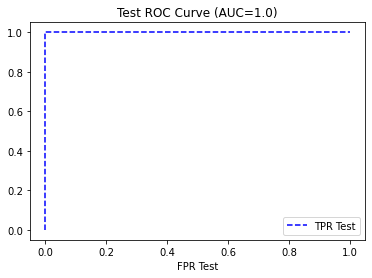

In [96]:
roc_df_test_rnn.plot(
    x="FPR Test",
    y="TPR Test",
    color="blue",
    style="--",
    xlim=([-0.05, 1.05]),
    title=f"Test ROC Curve (AUC={auc_test_rnn})",
)